In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import spacy   
from nltk.corpus import stopwords 
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import re
import string
from wordcloud import WordCloud
from collections import Counter

In [2]:

ds = load_dataset("allenai/scitldr", "AIC")

train_dataset = load_dataset("allenai/scitldr", "AIC", split="train")
valid_dataset = load_dataset("allenai/scitldr", "AIC", split="validation")
test_dataset  = load_dataset("allenai/scitldr", "AIC", split="test")

train_df = train_dataset.to_pandas()
valid_df = valid_dataset.to_pandas()
test_df = test_dataset.to_pandas()


In [3]:
train_df.head()

source  \
0  [Due to the success of deep learning to solvin...   
1  [The backpropagation (BP) algorithm is often t...   
2  [We introduce the 2-simplicial Transformer, an...   
3  [We present Tensor-Train RNN (TT-RNN), a novel...   
4  [Recent efforts on combining deep models with ...   

                                       source_labels  \
0  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                        rouge_scores    paper_id    ic  \
0  [0.3018868, 0.37209302, 0.6037736, 0.57142854,...   SysEexbRb  True   
1  [0.0, 0.0, 0.13043478, 0.14285713, 0.0, 0.1176...  SygvZ209F7  True   
2  [0.33333334, 0.8888889, 0.11428571, 0.0, 0.269...  rkecJ6VFvr  True   
3  [0.06666666, 0.06451613, 0.060606055, 0.137931...   HJJ0w--0W  True   
4  [0.27777776, 0.57142854, 0.09523809, 0.3428571...   HyH9lbZAW  True   

                                              target  
0  [We provide necessary and sufficient analytica...  
1  [Biologically plausible learning algorithms, p...  
2  [We introduce the 2-simplicial Transformer and...  
3  [Accurate forecasting over very long time hori...  
4  [We propose a variational message-passing algo...

In [4]:
valid_df.head()

source  \
0  [Mixed precision training (MPT) is becoming a ...   
1  [Many real-world problems, e.g. object detecti...   
2  [Foveation is an important part of human visio...   
3  [We explore the concept of co-design in the co...   
4  [Batch Normalization (BatchNorm) has shown to ...   

                                       source_labels  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2                                    [0, 0, 1, 0, 0]   
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                        rouge_scores    paper_id     ic  \
0  [0.24, 0.26086956, 0.19999999, 0.3809524, 0.20...  rJlnfaNYvB   True   
1  [0.054054048, 0.29268292, 0.974359, 0.19512194...  rJVoEiCqKQ   True   
2   [0.11764705, 0.11764705, 0.3529412, 0.0, 0.1875]  rkldVXKU8H  False   
3  [0.12499999, 0.4888889, 0.20408162, 0.14999999...  BJfIVjAcKm   True   
4  [0.19999999, 0.24, 0.4, 0.23809524, 0.08, 0.32...  BJlEEaEFDS   True   

                                              target  
0  [We devise adaptive loss scaling to improve mi...  
1  [We present a novel approach for learning to p...  
2  [We compare object recognition performance on ...  
3  [We develop methods to train deep neural model...  
4  [Investigation of how BatchNorm causes adversa...

In [5]:
test_df.head()

source  \
0  [Incremental class learning involves sequentia...   
1  [Multi-view learning can provide self-supervis...   
2  [We show how discrete objects can be learnt in...   
3  [Most recent gains in visual recognition have ...   
4  [In recent years, deep neural networks have de...   

                                       source_labels  \
0  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
2  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                        rouge_scores    paper_id    ic  \
0  [0.28571427, 0.18181817, 0.22727272, 0.2666666...   SJ1Xmf-Rb  True   
1  [0.2, 0.0, 0.15789473, 0.0, 0.1081081, 0.0, 0....  S1xzyhR9Y7  True   
2  [0.9787234, 0.33333334, 0.41509435, 0.14634146...   HJDUjKeA-  True   
3  [0.11764705, 0.14634146, 0.19999999, 0.1666666...  BJgLg3R9KQ  True   
4  [0.0, 0.058823526, 0.27027026, 0.14814815, 0.1...  BklpOo09tQ  True   

                                              target  
0  [FearNet is a memory efficient neural-network,...  
1  [Multi-view learning improves unsupervised sen...  
2  [We show how discrete objects can be learnt in...  
3  [A large-scale dataset for training attention ...  
4  [We proposed a time-efficient defense method a...

In [6]:
print('Train Dataset Shape:', train_df.shape)
print('Validation Dataset Shape:', valid_df.shape)
print('Test Dataset Shape:', test_df.shape)

Train Dataset Shape: (1992, 6)
Validation Dataset Shape: (619, 6)
Test Dataset Shape: (618, 6)


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   source         1992 non-null   object
 1   source_labels  1992 non-null   object
 2   rouge_scores   1992 non-null   object
 3   paper_id       1992 non-null   object
 4   ic             1992 non-null   bool  
 5   target         1992 non-null   object
dtypes: bool(1), object(5)
memory usage: 79.9+ KB


train_df["source"][0]

In [8]:
train_df["source"][0]

array(['Due to the success of deep learning to solving a variety of challenging machine learning tasks, there is a rising interest in understanding loss functions for training neural networks from a theoretical aspect.',
       'Particularly, the properties of critical points and the landscape around them are of importance to determine the convergence performance of optimization algorithms.',
       'In this paper, we provide a necessary and sufficient characterization of the analytical forms for the critical points (as well as global minimizers) of the square loss functions for linear neural networks.',
       'We show that the analytical forms of the critical points characterize the values of the corresponding loss functions as well as the necessary and sufficient conditions to achieve global minimum.',
       'Furthermore, we exploit the analytical forms of the critical points to characterize the landscape properties for the loss functions of linear neural networks and shallow ReLU 

In [9]:
source_train = train_df["source"].apply(lambda x: " ".join(x))
target_train = train_df["target"].apply(lambda x: " ".join(x))
source_valid = valid_df["source"].apply(lambda x: " ".join(x))
target_valid = valid_df["target"].apply(lambda x: " ".join(x))
source_test = test_df["source"].apply(lambda x: " ".join(x))
target_test = test_df["target"].apply(lambda x: " ".join(x))

In [10]:
source_train

0       Due to the success of deep learning to solving...
1       The backpropagation (BP) algorithm is often th...
2       We introduce the 2-simplicial Transformer, an ...
3       We present Tensor-Train RNN (TT-RNN), a novel ...
4       Recent efforts on combining deep models with p...
                              ...                        
1987    Semi-supervised learning, i.e. jointly learnin...
1988    Model-free reinforcement learning (RL) has bee...
1989    We introduce a neural architecture to perform ...
1990    Machine learned large-scale retrieval systems ...
1991    The ability to autonomously explore and naviga...
Name: source, Length: 1992, dtype: object

In [11]:
df_train = pd.DataFrame({'source': source_train, 'target': target_train})
df_valid = pd.DataFrame({'source': source_valid, 'target': target_valid})
df_test = pd.DataFrame({'source': source_test, 'target': target_test})

In [12]:
df_valid

source  \
0    Mixed precision training (MPT) is becoming a p...   
1    Many real-world problems, e.g. object detectio...   
2    Foveation is an important part of human vision...   
3    We explore the concept of co-design in the con...   
4    Batch Normalization (BatchNorm) has shown to b...   
..                                                 ...   
614  Policy gradients methods often achieve better ...   
615  The softmax function is widely used to train d...   
616  A fundamental question in reinforcement learni...   
617  Backpropagation is driving today's artificial ...   
618  This paper proposes and demonstrates a surpris...   

                                                target  
0    We devise adaptive loss scaling to improve mix...  
1    We present a novel approach for learning to pr...  
2    We compare object recognition performance on i...  
3    We develop methods to train deep neural models...  
4    Investigation of how BatchNorm causes adversar...  
..                                                 ...  
614  Linking Wasserstein-trust region entropic poli...  
615  The discriminative capability of softmax for l...  
616  We adapt Q-learning with UCB-exploration bonus...  
617  Perturbations can be used to train feedback we...  
618  We identify some universal patterns (i.e., hol...  

[619 rows x 2 columns]

In [13]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [14]:
stop_words = set(stopwords.words('english'))

In [15]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

In [16]:
def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'\[.*?\]', '', text) 
    text = re.sub(r'https?://\S+|www\.\S+', '', text) 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words]
    return " ".join(tokens)


In [17]:
tqdm.pandas(desc="Preprocessing Training Data")
clean_train_source = source_train.progress_apply(preprocess_text)
clean_train_target = target_train.progress_apply(preprocess_text)
tqdm.pandas(desc="Preprocessing Validation Data")
clean_valid_source = source_valid.progress_apply(preprocess_text)
clean_valid_target = target_valid.progress_apply(preprocess_text)
tqdm.pandas(desc="Preprocessing Testing Data")
clean_test_source = source_test.progress_apply(preprocess_text)
clean_test_target = target_test.progress_apply(preprocess_text)

Preprocessing Testing Data: 100%|██████████| 618/618 [00:04<00:00, 147.62it/s]


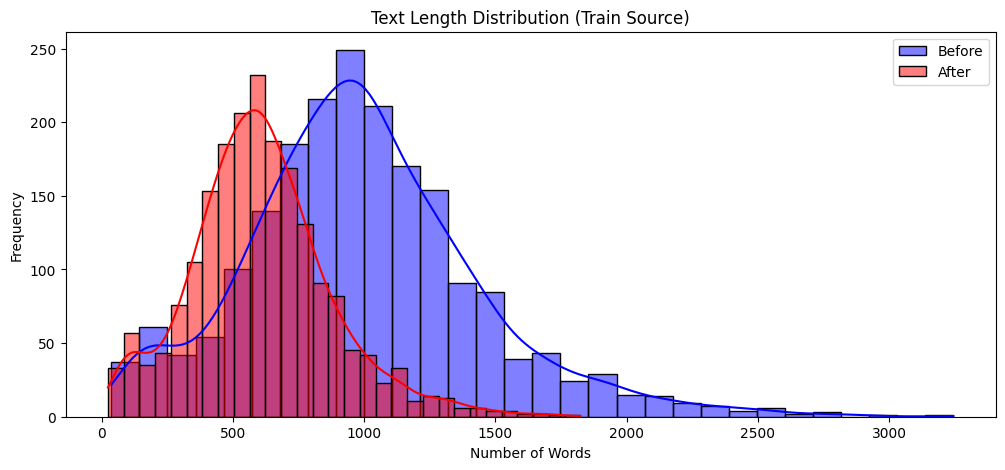

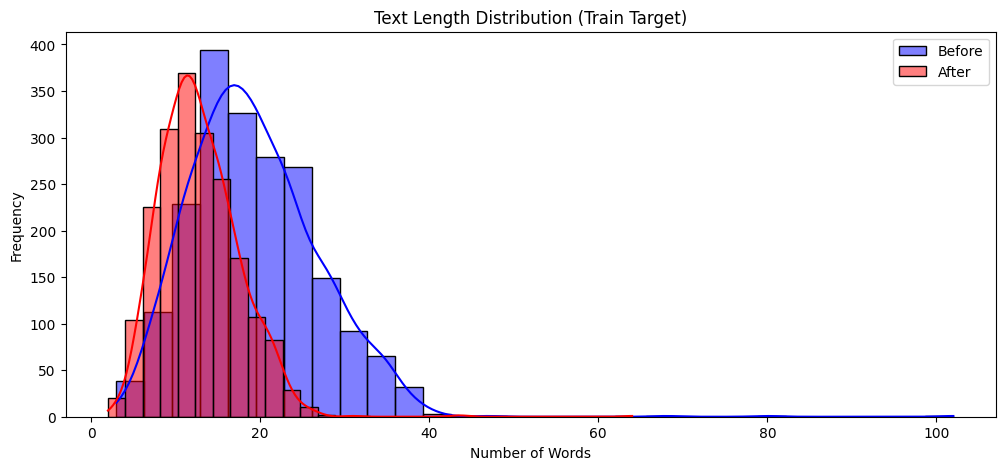

In [18]:
def plot_text_length_distribution(before, after, title):
    plt.figure(figsize=(12, 5))
    sns.histplot(before.str.split().apply(len), bins=30, kde=True, label="Before", color="blue")
    sns.histplot(after.str.split().apply(len), bins=30, kde=True, label="After", color="red")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.show()

plot_text_length_distribution(source_train, clean_train_source, "Text Length Distribution (Train Source)")
plot_text_length_distribution(target_train, clean_train_target, "Text Length Distribution (Train Target)")


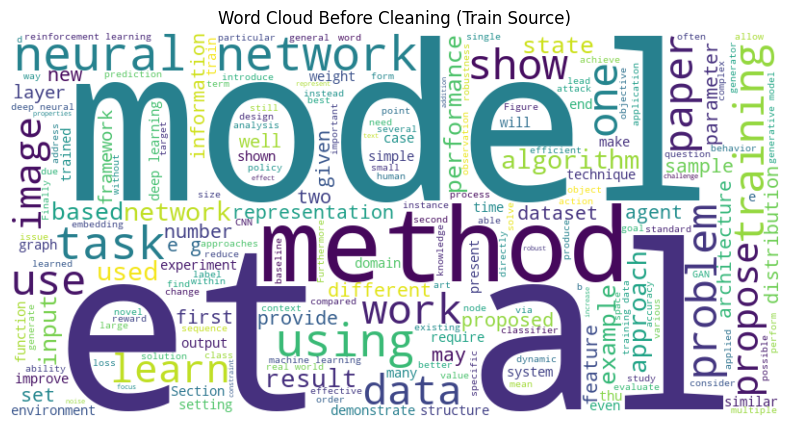

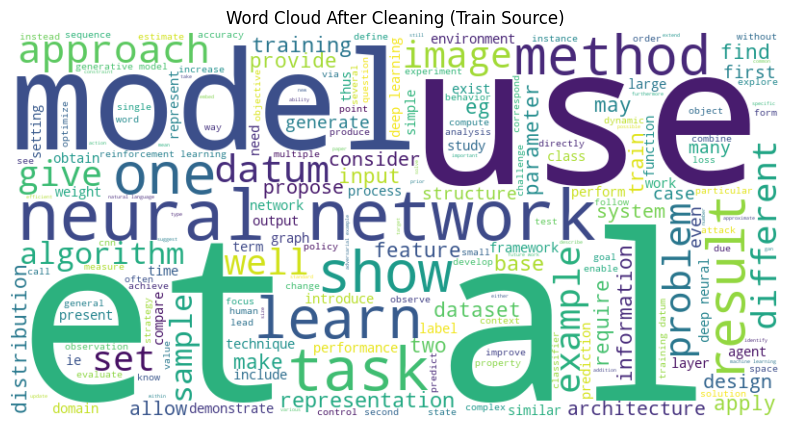

In [19]:
def plot_wordcloud(texts, title):
    text = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(source_train, "Word Cloud Before Cleaning (Train Source)")
plot_wordcloud(clean_train_source, "Word Cloud After Cleaning (Train Source)")


C:\Users\zecil\AppData\Local\Temp\ipykernel_25004\33325752.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


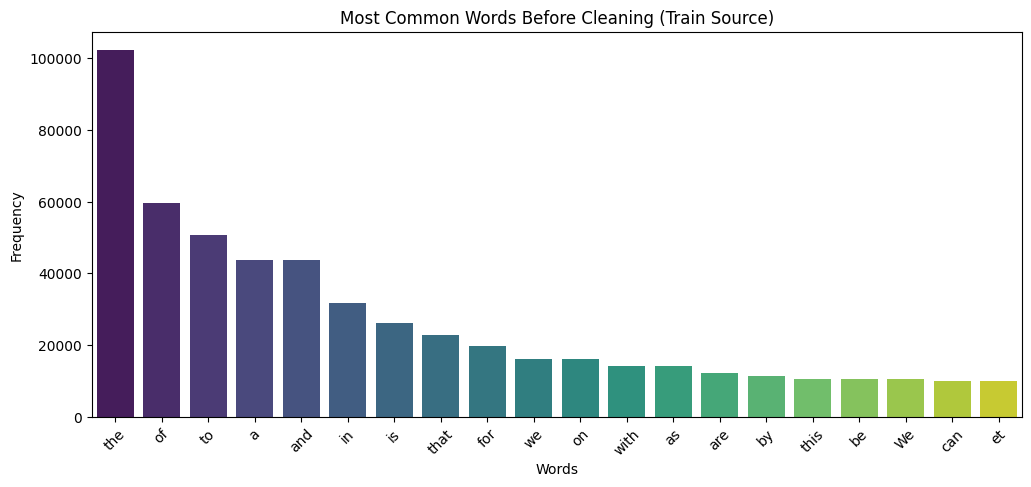

C:\Users\zecil\AppData\Local\Temp\ipykernel_25004\33325752.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


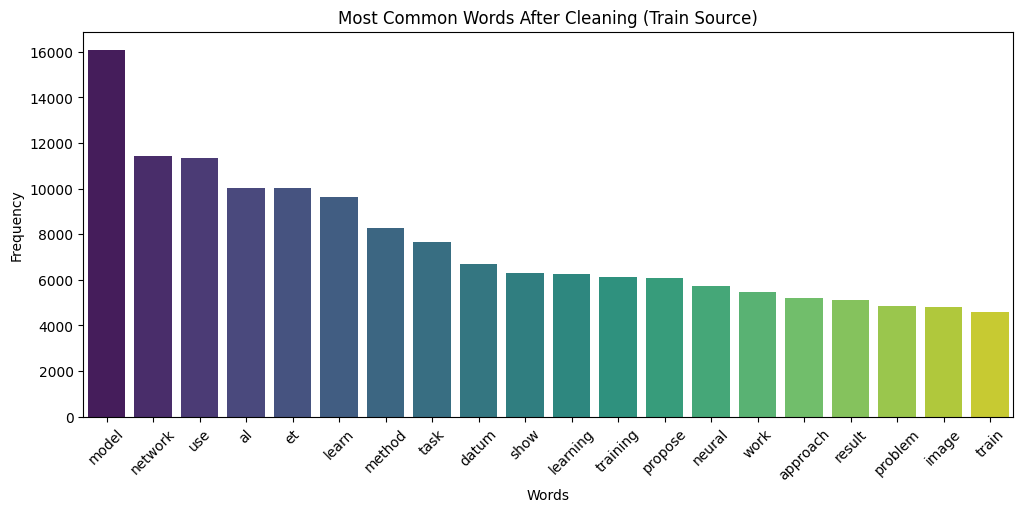

In [20]:
def plot_most_common_words(texts, title, n=20):
    words = " ".join(texts).split()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(n)
    words, counts = zip(*most_common_words)
    
    plt.figure(figsize=(12, 5))
    sns.barplot(x=list(words), y=list(counts), palette="viridis")
    plt.xticks(rotation=45)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

plot_most_common_words(source_train, "Most Common Words Before Cleaning (Train Source)")
plot_most_common_words(clean_train_source, "Most Common Words After Cleaning (Train Source)")

In [21]:
def generate_embeddings(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        batch = texts[i : i + batch_size]
        batch_embeddings = sbert_model.encode(batch, convert_to_tensor=True).cpu().numpy()
        embeddings.extend(batch_embeddings)
    return embeddings

source_train_embeddings = generate_embeddings(clean_train_source.tolist())

Generating Embeddings: 100%|██████████| 63/63 [00:31<00:00,  2.02it/s]


In [22]:
source_train_embeddings

[array([-6.57065213e-03, -3.22480649e-02,  4.14396673e-02, -9.74197313e-03,
        -4.79102172e-02,  5.59213199e-03, -5.76944984e-02,  3.76786850e-02,
        -6.67655393e-02, -5.07740816e-03, -2.46917699e-02, -6.91685304e-02,
         5.22690304e-02, -2.40507852e-02, -2.24282295e-02, -2.03174017e-02,
        -1.92598011e-02,  6.37681484e-02, -5.27157485e-02, -4.58985157e-02,
         9.13179293e-02,  2.86667328e-02, -2.81746536e-02, -1.73984300e-02,
        -8.23578387e-02,  1.03022335e-02, -1.86409056e-02, -4.92154562e-04,
        -1.11622363e-02, -4.92556654e-02,  2.42632031e-02,  7.22092539e-02,
         3.24171074e-02,  4.13971506e-02, -7.57527053e-02,  1.07047349e-01,
        -1.39460549e-01, -3.19721038e-03,  3.37110460e-02, -1.03478907e-02,
        -8.94617215e-02, -6.34574192e-03,  3.13378014e-02, -6.39520139e-02,
         1.36185661e-01,  4.88233157e-02, -7.27322623e-02, -7.53097534e-02,
         4.17843424e-02, -3.74676771e-02, -7.75397271e-02, -1.47447819e-02,
         3.8

In [23]:
# FAISS (Facebook AI Similarity Search) for efficiently search for similar text embeddings.
import faiss

# Convert embeddings to a NumPy array
source_train_embeddings_np = np.array(source_train_embeddings).astype("float32")

# Create a FAISS index
index = faiss.IndexFlatL2(source_train_embeddings_np.shape[1])  # L2 (Euclidean) distance
index.add(source_train_embeddings_np)  # Add embeddings to the index

# Example: Search for the 5 most similar documents to the first document
query_embedding = source_train_embeddings_np[0].reshape(1, -1)  # Querying the first document
D, I = index.search(query_embedding, 5)  # Returns distances (D) and indices (I)

print("Top 5 similar document indices:", I)
print("Top 5 similarity scores:", D)



Top 5 similar document indices: [[   0  883  286  582 1767]]
Top 5 similarity scores: [[0.         0.454347   0.4552548  0.4749148  0.47734597]]


In [24]:
# T5 (Text-to-Text Transfer Transformer) used to generate summaries from source text.

from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load pre-trained T5 model and tokenizer
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")

def summarize_text(text, max_length=50):
    input_text = "summarize: " + text  # Prefix needed for T5
    input_ids = t5_tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    
    # Generate summary
    summary_ids = t5_model.generate(input_ids, max_length=max_length, num_beams=4, early_stopping=True)
    return t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Example: Summarizing the first document
example_summary = summarize_text(source_train[0])
print("Original Text:", source_train[0])
print("Summarized Text:", example_summary)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Original Text: Due to the success of deep learning to solving a variety of challenging machine learning tasks, there is a rising interest in understanding loss functions for training neural networks from a theoretical aspect. Particularly, the properties of critical points and the landscape around them are of importance to determine the convergence performance of optimization algorithms. In this paper, we provide a necessary and sufficient characterization of the analytical forms for the critical points (as well as global minimizers) of the square loss functions for linear neural networks. We show that the analytical forms of the critical points characterize the values of the corresponding loss functions as well as the necessary and sufficient conditions to achieve global minimum. Furthermore, we exploit the analytical forms of the critical points to characterize the landscape properties for the loss functions of linear neural networks and shallow ReLU networks. One particular conclusi

In [26]:
# BERTopic and LDA are used for topic modeling and document clustering.

# Implementation using BERTopic:
from bertopic import BERTopic

# Initialize and fit BERTopic model
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(clean_train_source.tolist(), np.array(source_train_embeddings))

# Display the topics
topic_model.get_topic_info().head(10)

# Visualize the topics
topic_model.visualize_barchart(top_n_topics=10)

# Implementation using LDA (Latent Dirichlet Allocation):
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Tokenize the cleaned source text
tokenized_texts = [text.split() for text in clean_train_source.tolist()]

# Create a dictionary and corpus
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)

# Display top words for each topic
for idx, topic in lda_model.show_topics(formatted=True, num_words=10):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.014*"network" + 0.009*"model" + 0.008*"use" + 0.008*"image" + 0.007*"layer" + 0.007*"datum" + 0.007*"information" + 0.006*"representation" + 0.006*"neural" + 0.006*"learn"
Topic 1: 0.014*"learn" + 0.012*"agent" + 0.011*"use" + 0.009*"task" + 0.009*"policy" + 0.008*"reward" + 0.008*"learning" + 0.007*"algorithm" + 0.007*"method" + 0.007*"problem"
Topic 2: 0.013*"language" + 0.013*"question" + 0.010*"entity" + 0.010*"model" + 0.010*"answer" + 0.008*"knowledge" + 0.007*"dataset" + 0.007*"use" + 0.006*"reasoning" + 0.006*"relation"
Topic 3: 0.027*"model" + 0.015*"task" + 0.010*"learn" + 0.009*"domain" + 0.008*"use" + 0.008*"et" + 0.008*"al" + 0.008*"image" + 0.007*"network" + 0.006*"propose"
Topic 4: 0.016*"model" + 0.014*"al" + 0.014*"et" + 0.010*"adversarial" + 0.009*"use" + 0.009*"datum" + 0.009*"network" + 0.008*"method" + 0.008*"training" + 0.007*"distribution"
Topic 5: 0.021*"model" + 0.012*"use" + 0.008*"method" + 0.008*"learn" + 0.006*"algorithm" + 0.006*"learning" + 0.0

In [ ]:
# Use FAISS for fast similarity search over the source document embeddings.

# Use T5 to generate summaries from documents.

# Use BERTopic and LDA for topic modeling and document clustering.

In [ ]:
# Evaluate BERTopic and LDA Clustering
# We'll use the Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) scores to evaluate how well our clustering models (BERTopic & LDA) group similar documents.

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Ground truth labels (assuming target_train is used as labels)
true_labels = target_train.factorize()[0]  # Convert categories to numerical labels

# BERTopic Clustering Accuracy
ari_bertopic = adjusted_rand_score(true_labels, topics)
nmi_bertopic = normalized_mutual_info_score(true_labels, topics)

print(f"BERTopic - Adjusted Rand Index (ARI): {ari_bertopic:.4f}")
print(f"BERTopic - Normalized Mutual Information (NMI): {nmi_bertopic:.4f}")

# LDA Clustering Accuracy
lda_labels = [max(lda_model.get_document_topics(bow), key=lambda x: x[1])[0] for bow in corpus]

ari_lda = adjusted_rand_score(true_labels, lda_labels)
nmi_lda = normalized_mutual_info_score(true_labels, lda_labels)

print(f"LDA - Adjusted Rand Index (ARI): {ari_lda:.4f}")
print(f"LDA - Normalized Mutual Information (NMI): {nmi_lda:.4f}")


In [ ]:
# Evaluate T5 Summarization
# For summarization, we'll compare T5-generated summaries with ground-truth summaries using ROUGE scores (Recall-Oriented Understudy for Gisting Evaluation).

from datasets import load_metric

rouge = load_metric("rouge")

# Generate summaries for validation dataset
generated_summaries = [summarize_text(text) for text in source_valid[:100]]  # Limiting to 100 for efficiency
reference_summaries = target_valid[:100].tolist()

# Compute ROUGE scores
rouge_scores = rouge.compute(predictions=generated_summaries, references=reference_summaries)

print("ROUGE-1:", rouge_scores["rouge1"].mid.fmeasure)
print("ROUGE-2:", rouge_scores["rouge2"].mid.fmeasure)
print("ROUGE-L:", rouge_scores["rougeL"].mid.fmeasure)


In [ ]:
# 1. according to your data - why did you choose this model
# 2. what different did you do in this model
# 3. did you do data optimization to make your model good - different than other model